same mindset but for reggression problems

In [10]:
from datetime import datetime
import time,pytz
import os, glob, subprocess, sys, uuid
from tqdm import tqdm

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

import keras

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

GLOBAL_RANDOM_SEED = 42

random.seed(GLOBAL_RANDOM_SEED)
np.random.seed(GLOBAL_RANDOM_SEED)
tf.random.set_seed(GLOBAL_RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
initializer = keras.initializers.GlorotUniform(seed=GLOBAL_RANDOM_SEED)

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


I0000 00:00:1756808347.489809   44359 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5223 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
import pandas as pd

# ========== LOAD & CLEAN ==========
file_path = "./data/concrete-dataset/Concrete_Data.xls"
df = pd.read_excel(file_path)

# rename columns (normalizing column names)
df.columns = [
    "Cement",
    "BlastFurnaceSlag",
    "FlyAsh",
    "Water",
    "Superplasticizer",
    "CoarseAggregate",
    "FineAggregate",
    "Age",
    "target"  # compressive strength
]

# inspect
print(df.head())
print(df.info())

   Cement  BlastFurnaceSlag  FlyAsh  Water  Superplasticizer  CoarseAggregate  \
0   540.0               0.0     0.0  162.0               2.5           1040.0   
1   540.0               0.0     0.0  162.0               2.5           1055.0   
2   332.5             142.5     0.0  228.0               0.0            932.0   
3   332.5             142.5     0.0  228.0               0.0            932.0   
4   198.6             132.4     0.0  192.0               0.0            978.4   

   FineAggregate  Age     target  
0          676.0   28  79.986111  
1          676.0   28  61.887366  
2          594.0  270  40.269535  
3          594.0  365  41.052780  
4          825.5  360  44.296075  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cement            1030 non-null   float64
 1   BlastFurnaceSlag  1030 non-null   float64
 2   FlyA

In [12]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from skrebate import ReliefF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from sklearn.ensemble import VotingClassifier, StackingClassifier

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import KFold, cross_val_score

# ========== SPLIT ==========
X = df.drop('target', axis=1)
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=GLOBAL_RANDOM_SEED
)

# ========== REGRESSORS & ENSEMBLES ==========
base_learners = [
    ("lr", LinearRegression()),
    ("dt", DecisionTreeRegressor(random_state=GLOBAL_RANDOM_SEED)),
    ("rf", RandomForestRegressor(n_estimators=200, random_state=GLOBAL_RANDOM_SEED, n_jobs=1)),
    ("svr", SVR()),
    ("knn", KNeighborsRegressor()),
    ("xgb", XGBRegressor(objective="reg:squarederror", random_state=GLOBAL_RANDOM_SEED, n_jobs=1))
]


# VotingRegressor expects estimators list of (name, estimator) tuples
voting_reg = VotingRegressor(estimators=base_learners, n_jobs=-1)

# StackingRegressor — use LinearRegression as final estimator (or another regressor)
stacking_reg = StackingRegressor(
    estimators=base_learners,
    final_estimator=LinearRegression(),
    passthrough=True,
    cv=5,
    n_jobs=-1
)

selectors = {
    "FReg": [("select", SelectKBest(f_regression, k=8))],
    "MutualInfo": [("select", SelectKBest(mutual_info_regression, k=8))],
    # If you have skrebate and want to use it (check docs): it supports regression/RRelief variants
    # "ReliefF": [("select", ReliefF(n_features_to_select=9))],
    "PCA": [("reduce", PCA(n_components=8))]
}

models = {
    "LinReg": LinearRegression(),
    "DecTree": DecisionTreeRegressor(random_state=GLOBAL_RANDOM_SEED),
    "RandForest": RandomForestRegressor(n_estimators=200, random_state=GLOBAL_RANDOM_SEED, n_jobs=1),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=GLOBAL_RANDOM_SEED, n_jobs=1),
    "Voting": voting_reg,
    "Stacking": stacking_reg
}

# ========== PIPELINE & EVALUATION (regression) ==========
from imblearn.pipeline import Pipeline as ImbPipeline  # OK to reuse pipeline class
results = []

for sel_name, sel_steps in selectors.items():
    for model_name, model in models.items():
        steps = [("scaler", StandardScaler())] + sel_steps + [("model", model)]
        pipe = ImbPipeline(steps)
        pipe.fit(X_train, y_train)

        # regression predictions
        y_pred = pipe.predict(X_test)

        # metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        ev = explained_variance_score(y_test, y_pred)

        # Extract selected feature names in a robust way
        def get_selected_features(pipe, X_train):
            try:
                if "select" in pipe.named_steps:
                    sel = pipe.named_steps["select"]
                    if hasattr(sel, "get_support"):
                        mask = sel.get_support()
                        return X_train.columns[mask].tolist()
                    if hasattr(sel, "top_features_"):
                        idxs = list(sel.top_features_)
                        return [X_train.columns[i] for i in idxs]
                if "reduce" in pipe.named_steps:
                    pc = pipe.named_steps["reduce"]
                    if hasattr(pc, "n_components_"):
                        return [f"PC{i+1}" for i in range(pc.n_components_)]
            except Exception as e:
                return [f"[Error extracting features: {e}]"]
            return ["[No selector to extract from]"]

        selected_features = get_selected_features(pipe, X_train)

        results.append({
            "Selector": sel_name,
            "Model": model_name,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "ExplainedVar": ev,
            "Selected Features": selected_features
        })

# summary
df_results = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None)
print(df_results.sort_values(by="RMSE").to_string(index=False))

# # ========== HITMAPS ==========
# metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
# cmap_dict = {
#     "Accuracy": "magma",
#     "Precision": "coolwarm",
#     "Recall": "cubehelix",
#     "F1 Score": "YlGnBu",
#     "AUC": "viridis"
# }

# plt.figure(figsize=(15, 12))
# sns.set_theme(style="whitegrid")

# for i, metric in enumerate(metrics, 1):
#     plt.subplot(3, 2, i)
#     metric_matrix = df_results.pivot(index="Selector", columns="Model", values=metric)
#     sns.heatmap(metric_matrix, annot=True, fmt=".3f", cmap=cmap_dict[metric], cbar_kws={'label': metric})
#     plt.title(f"{metric} by Selector and Model")
#     plt.xlabel("Model")
#     plt.ylabel("Feature Selector")

# plt.tight_layout()
# plt.show()

  Selector      Model       MSE     RMSE      MAE       R2  ExplainedVar                                                                                Selected Features
      FReg   Stacking 19.693528 4.437739 2.989102 0.923574      0.924772 [Cement, BlastFurnaceSlag, FlyAsh, Water, Superplasticizer, CoarseAggregate, FineAggregate, Age]
MutualInfo   Stacking 19.693528 4.437739 2.989102 0.923574      0.924772 [Cement, BlastFurnaceSlag, FlyAsh, Water, Superplasticizer, CoarseAggregate, FineAggregate, Age]
MutualInfo    XGBoost 19.822068 4.452198 2.906828 0.923075      0.924533 [Cement, BlastFurnaceSlag, FlyAsh, Water, Superplasticizer, CoarseAggregate, FineAggregate, Age]
      FReg    XGBoost 19.822068 4.452198 2.906828 0.923075      0.924533 [Cement, BlastFurnaceSlag, FlyAsh, Water, Superplasticizer, CoarseAggregate, FineAggregate, Age]
      FReg RandForest 31.066895 5.573768 3.788740 0.879437      0.882058 [Cement, BlastFurnaceSlag, FlyAsh, Water, Superplasticizer, CoarseAggregate, 

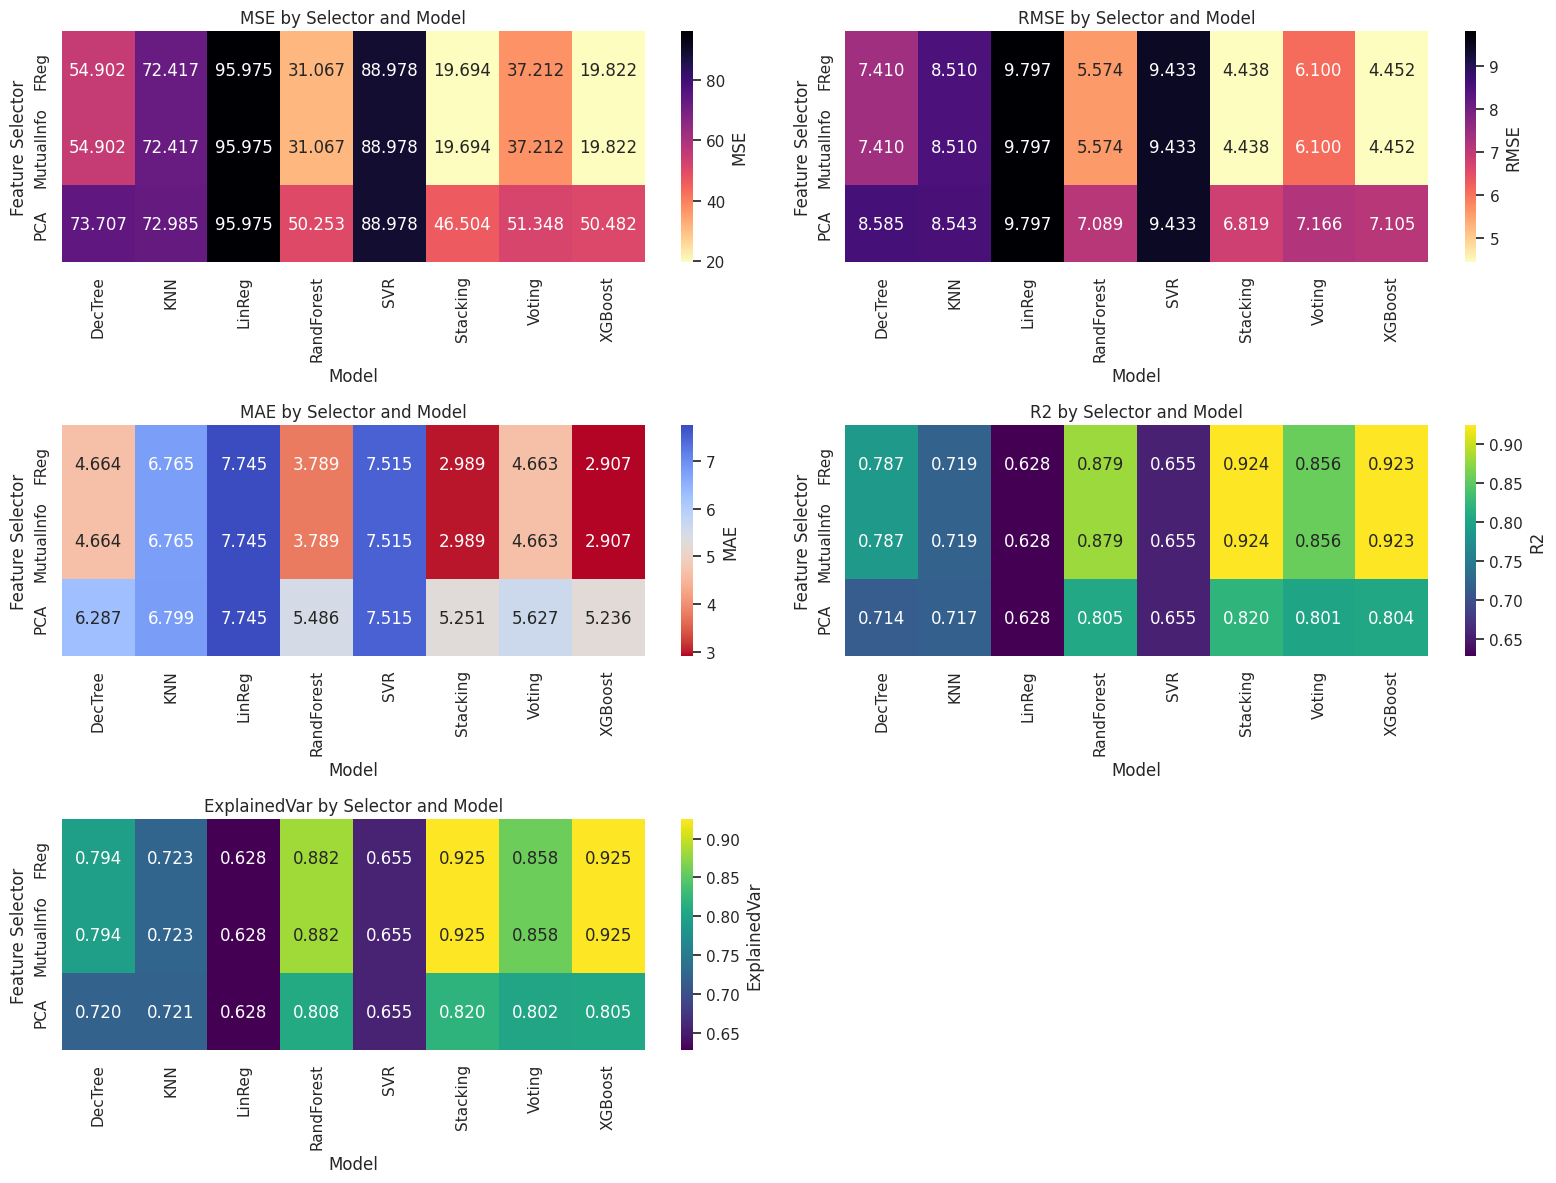

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["MSE", "RMSE", "MAE", "R2", "ExplainedVar"]
cmap_dict = {
    "MSE": "magma_r",          # reversed so lower MSE is darker
    "RMSE": "magma_r",
    "MAE": "coolwarm_r",
    "R2": "viridis",            # higher is better
    "ExplainedVar": "viridis"
}

plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    metric_matrix = df_results.pivot(index="Selector", columns="Model", values=metric)
    sns.heatmap(metric_matrix, annot=True, fmt=".3f", cmap=cmap_dict[metric], cbar_kws={'label': metric})
    plt.title(f"{metric} by Selector and Model")
    plt.xlabel("Model")
    plt.ylabel("Feature Selector")

plt.tight_layout()
plt.show()